In [11]:
from custom_filter import * 

In [26]:
f = no_variance_filter
# --------------------------------------------------
base_dir = '../../outputs'
import json 
import os 
import numpy as np 
from omegaconf import OmegaConf 

results_in_directories = []
for root, dirs, files in os.walk(base_dir):
    if 'config.yaml' in files:
        flags = OmegaConf.load(os.path.join(root, 'config.yaml'))
        if not f(flags, 'grad', ['resnet18','vgg16', 'efficient_b0' ]): # 'resnet18', 'vgg16']):
            continue
        print(flags)
        result = json.load(open(os.path.join(root, 'evaluation.json'), 'rb'))
        results_in_directories.append([flags, result])
        print(list(result.keys())[:10])
print(len(results_in_directories))


{'encoder': 'vgg16', 'data_path': '/data/ImageNet1k', 'bbox_path': '/data/ILSVRC2012_bbox_val', 'input_attrib': 'grad', 'fixed_samples': None, 'method': 'cls', 'device': 'cuda:0', 'layer_ratio': 1.0, 'alpha': None, 'save_name': 'True_0.1_1.0', 'quantile': 0.1, 'p_value_threshold': 0.05, 'variance_conservation': True, 'exact_variance': True, 'gamma_infinity': True, 'success': True}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{'encoder': 'vgg16', 'data_path': '/data/ImageNet1k', 'bbox_path': '/data/ILSVRC2012_bbox_val', 'input_attrib': 'grad', 'fixed_samples': None, 'method': 'cls', 'device': 'cuda:0', 'layer_ratio': 1.0, 'alpha': None, 'save_name': 'False_0.1_1.0', 'quantile': 0.1, 'p_value_threshold': 0.05, 'variance_conservation': False, 'exact_variance': True, 'gamma_infinity': True, 'success': True}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
{'encoder': 'vgg16', 'data_path': '/data/ImageNet1k', 'bbox_path': '/data/ILSVRC2012_bbox_val', 'input_attrib': 'grad', 'fixed_s

In [27]:
N_samples = 50000

In [28]:
from tqdm import tqdm 

def custom_flag_condition(flag):
    condition = True 
    name = f"{flag.encoder}_{flags.method}_{flags.input_attrib}_{flag.layer_ratio}_{flag.quantile}_{flag.variance_conservation}"
    return name, condition 

condition_results = {}
for flag, results in tqdm(results_in_directories): 
    name, condition = custom_flag_condition(flag)
    if not condition :
        continue
    eval_results = {
        'morf_aopc' : {},
        'morf_lodds' :{},
        'morf_fracdiff' : {},
        'morf_acc' :{},
        'lerf_aopc' :{},
        'lerf_lodds' :{},
        'lerf_fracdiff' :{},
        'lerf_acc' :{},
        'mu_in':[],
        'mu_in_w':[],
    }
    assert name not in condition_results, f"{name} is already in condition_results. {flag}"
    reduced_eval_results =  {k:{} for k in eval_results.keys()}

    for idx in range(N_samples):
        for k, v in results[str(idx)].items():
            if k in ['morf', 'lerf']:
                for metric, ratio_results in v.items():
                    for ratio, value in ratio_results.items():
                        if ratio not in eval_results[f'{k}_{metric}']:
                            eval_results[f'{k}_{metric}'][float(ratio)] = []
                            reduced_eval_results[f'{k}_{metric}'][float(ratio)] = 0
                        eval_results[f'{k}_{metric}'][float(ratio)].append(float(value))
            elif k in ['mu_in_w', 'mu_in']:
                eval_results[k].append(float(v))
                
    for k, v in eval_results.items():
        if k in ['mu_in', 'mu_in_w'] :
            reduced_eval_results[f"{k}_mean"] = np.mean(v)
        else:
            for ratio, value in v.items():
                reduced_eval_results[f"{k}"][ratio] = np.mean(value)
            reduced_eval_results[f"{k}_ratio_mean"] = np.mean(list(reduced_eval_results[k].values()))
    condition_results[f'{name}'] = reduced_eval_results
    metric_names = [ k for k in  reduced_eval_results.keys() if 'mean' in k] 
    # print(f'{name}')

100%|██████████| 48/48 [02:43<00:00,  3.41s/it]


In [ ]:
import re 
print("| name ", end=" |")
metric_names = [ k for k in  reduced_eval_results.keys() if 'mean' in k] 
keys = list(condition_results.keys())
keys = sorted(keys)

for k in metric_names:
    sub_name = re.sub('_mean', "", k)
    sub_name = re.sub('_ratio', "", sub_name)
    print(sub_name, end= " | ")

dfs = {
    'encoder':[],
    'method':[],
    'input_attrib':[],
    'layer_ratio':[],
    'quantile':[],
    'variance_conservation':[],
    }

print()
print("|---|", end=" ")
for k in metric_names:
    print("---", end= " | ")
    dfs[k] = []
print()
for key in keys:
    print(key, end=" | ")
    if 'efficient_b0' in key:
        keyr = key.replace('efficient_b0', 'efficient-b0')
    else:
        keyr =key 
    encoder, method, input_attrib, layer_ratio, quantile, variance_conservation = keyr.split("_")
    dfs['encoder'].append(encoder)
    dfs['method'].append(method)
    dfs['input_attrib'].append(input_attrib)
    dfs['layer_ratio'].append(layer_ratio)
    dfs['quantile'].append(quantile)
    dfs['variance_conservation'].append(variance_conservation)
    for k in metric_names:
        print(f"{condition_results[key][k]:.3f}", end=" | ")
        dfs[k].append(condition_results[key][k])
    print()

| name  |morf_aopc | morf_lodds | morf_fracdiff | morf_acc | lerf_aopc | lerf_lodds | lerf_fracdiff | lerf_acc | mu_in | mu_in_w | 
|---| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
efficient_b0_cls_grad_0.3_0.05_False | 0.357 | -3.552 | 0.357 | 0.167 | 0.153 | -0.859 | 0.208 | 0.667 | 0.523 | 0.950 | 
efficient_b0_cls_grad_0.3_0.05_True | 0.355 | -3.209 | 0.355 | 0.333 | 0.240 | -2.201 | 0.263 | 0.500 | 0.521 | 0.946 | 
efficient_b0_cls_grad_0.3_0.1_False | 0.353 | -3.048 | 0.353 | 0.167 | 0.148 | -1.198 | 0.213 | 0.667 | 0.524 | 0.949 | 
efficient_b0_cls_grad_0.3_0.1_True | 0.346 | -2.621 | 0.346 | 0.167 | 0.182 | -1.262 | 0.186 | 0.667 | 0.521 | 0.943 | 
efficient_b0_cls_grad_0.5_0.05_False | 0.352 | -3.801 | 0.352 | 0.167 | 0.105 | -0.448 | 0.156 | 0.667 | 0.527 | 0.960 | 
efficient_b0_cls_grad_0.5_0.05_True | 0.362 | -3.082 | 0.362 | 0.167 | 0.259 | -2.574 | 0.259 | 0.500 | 0.524 | 0.947 | 
efficient_b0_cls_grad_0.5_0.1_False | 0.351 | -2.936 | 0.351 | 0.167 | 0.1

In [30]:
import pandas as pd 
df = pd.DataFrame(dfs)
df

,encoder,method,input_attrib,layer_ratio,quantile,variance_conservation,morf_aopc_ratio_mean,morf_lodds_ratio_mean,morf_fracdiff_ratio_mean,morf_acc_ratio_mean,lerf_aopc_ratio_mean,lerf_lodds_ratio_mean,lerf_fracdiff_ratio_mean,lerf_acc_ratio_mean,mu_in_mean,mu_in_w_mean
0,efficient-b0,cls,grad,0.3,0.05,False,0.357462,-3.551842,0.357462,0.166667,0.152765,-0.858766,0.208329,0.666667,0.522917,0.950252
1,efficient-b0,cls,grad,0.3,0.05,True,0.355316,-3.208895,0.355316,0.333333,0.240134,-2.201471,0.263119,0.500000,0.521260,0.945700
2,efficient-b0,cls,grad,0.3,0.1,False,0.353143,-3.047694,0.353143,0.166667,0.147867,-1.198287,0.213114,0.666667,0.523529,0.948955
3,efficient-b0,cls,grad,0.3,0.1,True,0.345803,-2.620890,0.345803,0.166667,0.182147,-1.262020,0.185614,0.666667,0.521203,0.943220
4,efficient-b0,cls,grad,0.5,0.05,False,0.352387,-3.801447,0.352387,0.166667,0.104996,-0.447909,0.156269,0.666667,0.526963,0.959801
5,efficient-b0,cls,grad,0.5,0.05,True,0.361565,-3.081896,0.361565,0.166667,0.259387,-2.573774,0.259387,0.500000,0.523620,0.946941
6,efficient-b0,cls,grad,0.5,0.1,False,0.350607,-2.936368,0.350607,0.166667,0.146043,-1.069631,0.182924,0.666667,0.528055,0.956116
7,efficient-b0,cls,grad,0.5,0.1,True,0.355007,-2.807393,0.355007,0.166667,0.234749,-1.732218,0.235432,0.500000,0.523506,0.945832
8,efficient-b0,cls,grad,0.9,0.05,False,0.354882,-3.331869,0.354882,0.166667,0.217931,-0.988233,0.225832,0.666667,0.537133,0.980750
9,efficient-b0,cls,grad,0.9,0.05,True,0.361960,-3.157169,0.361960,0.166667,0.294254,-2.642577,0.294254,0.333333,0.528413,0.955101


In [ ]:
import matplotlib.pyplot  as plt 
import seaborn as sns 
qs = ['0.05', '0.1']

for model in ['resnet18', 'vgg16',]:
    fig, ax = plt.subplots(1,1 ,figsize=(5,2.5))
    name='mu_in_w_mean'

    t = df[(df['encoder']==model)&(df['input_attrib']=='grad')&(df['layer_ratio']=='0.5')]
    sns.barplot(x='quantile', y='mu_in_w_mean', data=t, hue='variance_conservation', ax=ax, # s=100,   markers=['o', '*'],  style="variance_conservation",
                    palette=('blue', 'red'), hue_order=['True', 'False'], alpha=1.0)
    if model == "resnet18":
        ax.set_ylim(0.875, 0.96)
        # ax.legend(['without VC', 'with VC'],  loc='upper left', title=None) #
        ax.get_legend().remove()
        
    elif model == "vgg16":
        ax.set_ylim(0.94, 0.98)
        
        # ax.legend(['without VC', 'with VC'],  loc='upper left',title=None) #loc='lower right',
    elif model == "efficient-b0":
        # ax.set_ylim(0.94, 0.99)
        ax.legend(['without VC', 'with VC'], loc='upper left', title=None) #loc='lower right',    
    # ax.set_title(f"channel portion:{q}")
    # if q == '0.05':
    #     ax.get_legend().remove()
    # else:
    #     ax.set_yticklabels([])
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    # fig.supylabel(name)
    # fig.supxlabel("All Convolutions Ratio")
    # fig.suptitle(model)
    plt.tight_layout()
    plt.savefig(f"outputs/{model}_mu.pdf")

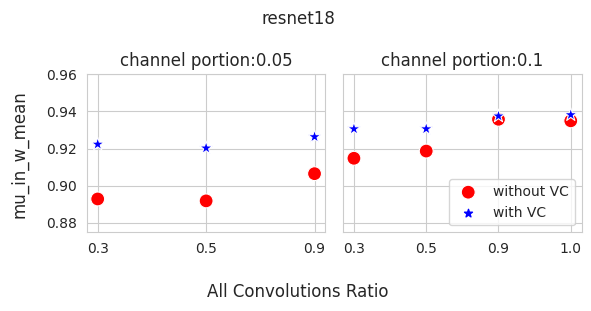

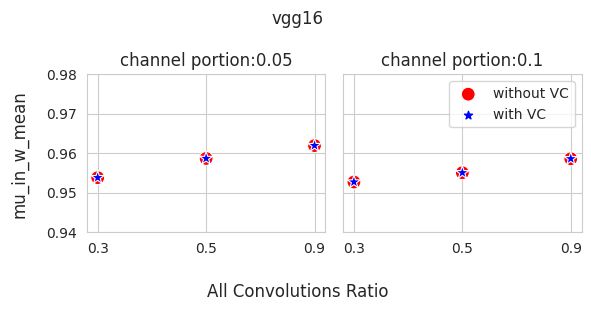

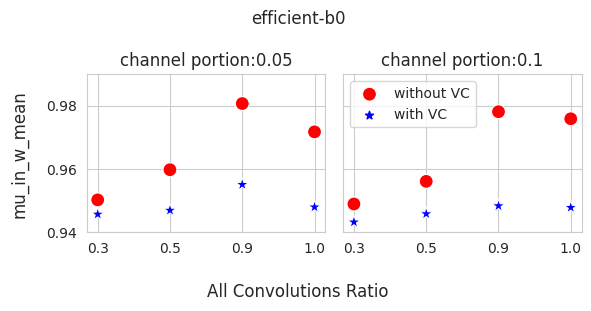

In [50]:
qs = ['0.05', '0.1']

for model in ['resnet18', 'vgg16', 'efficient-b0']:
    fig, axes = plt.subplots(1,2 ,figsize=(6,3))
    name='mu_in_w_mean'
    for q, ax in zip(qs, axes):
        t = df[(df['encoder']==model)&(df['input_attrib']=='grad')&(df['quantile']==q)]
        sns.scatterplot(x='layer_ratio', y='mu_in_w_mean', data=t, hue='variance_conservation', ax=ax, s=100, 
                        style="variance_conservation", markers=['o', '*'], palette=('blue', 'red'), hue_order=['True', 'False'], alpha=1.0)
        if model == "resnet18":
            ax.set_ylim(0.875, 0.96)
            ax.legend(['without VC', 'with VC'],  loc='lower right', title=None) #
        elif model == "vgg16":
            ax.set_ylim(0.94, 0.98)
            ax.legend(['without VC', 'with VC'],  loc='upper right',title=None) #loc='lower right',
        elif model == "efficient-b0":
            ax.set_ylim(0.94, 0.99)
            ax.legend(['without VC', 'with VC'], loc='upper left', title=None) #loc='lower right',    
        ax.set_title(f"channel portion:{q}")
        if q == '0.05':
            ax.get_legend().remove()
        else:
            ax.set_yticklabels([])
        ax.set_ylabel(None)
        ax.set_xlabel(None)
    fig.supylabel(name)
    fig.supxlabel("All Convolutions Ratio")
    fig.suptitle(model)
    plt.tight_layout()
    plt.savefig(f"outputs/{model}_mu.png")